In [19]:
##Некоторые полезные функции для работы с углами в косых сечениях

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
# import mplstereonet

def true_dip_from_two_app_dips(az_1,dip_1,az_2,dip_2):   ##Вычисление угла падения по двум косым сечениям
    ang_between=np.deg2rad(az_2-az_1)
    dip_1,dip_2= np.deg2rad(dip_1),np.deg2rad(dip_2)
    a=((np.tan(1.570-dip_1))**2+(np.tan(1.570-dip_2))**2-(np.tan(1.570-dip_1))*(np.tan(1.570-dip_2))*2*np.cos(ang_between))**0.5
    p=(a+(np.tan(1.570-dip_1))+(np.tan(1.570-dip_2)))/2
    H=2/a*((p*(p-a)*(p-np.tan(1.570-dip_1))*(p-np.tan(1.570-dip_2)))**0.5)
    betta=np.rad2deg(np.arctan(1/H))
    if az_1-az_2<180:
        az=az_1-np.rad2deg(np.arccos(H/np.tan(1.570-dip_1)))
    else: az=az_1+np.rad2deg(np.arccos(H/np.tan(1.570-dip_1)))
    return(az,betta)

def time_to_depth_angle(angle,speed):    ##переводит угол плоскости из времени в глубины при заданных скоростях
    angle_time=np.deg2rad(angle)
    ms=np.tan(angle_time)
    meters=ms*speed/2
    angle_depth=np.rad2deg(np.arctan(meters))
    return(angle_depth)

def angle_of_section(app_dip,true_dip):    ## вычисляет угол между прямым и косым сечением по углам падения в них
    b=1/np.tan(np.deg2rad(app_dip))
    c=1/np.tan(np.deg2rad(true_dip))
    section_angle=np.rad2deg(np.arccos(b/c))
    return(section_angle)

def apparent_angle(true_dip,section_angle):   ## вычисляет угол падения в косом сечении исходя из угла падения в прямом и разницы азимутов
    true_dip=np.deg2rad(true_dip)
    section_angle=np.deg2rad(section_angle)
    app_dip=np.rad2deg(np.arctan(np.tan(true_dip)*np.cos(section_angle)))
    return(app_dip)


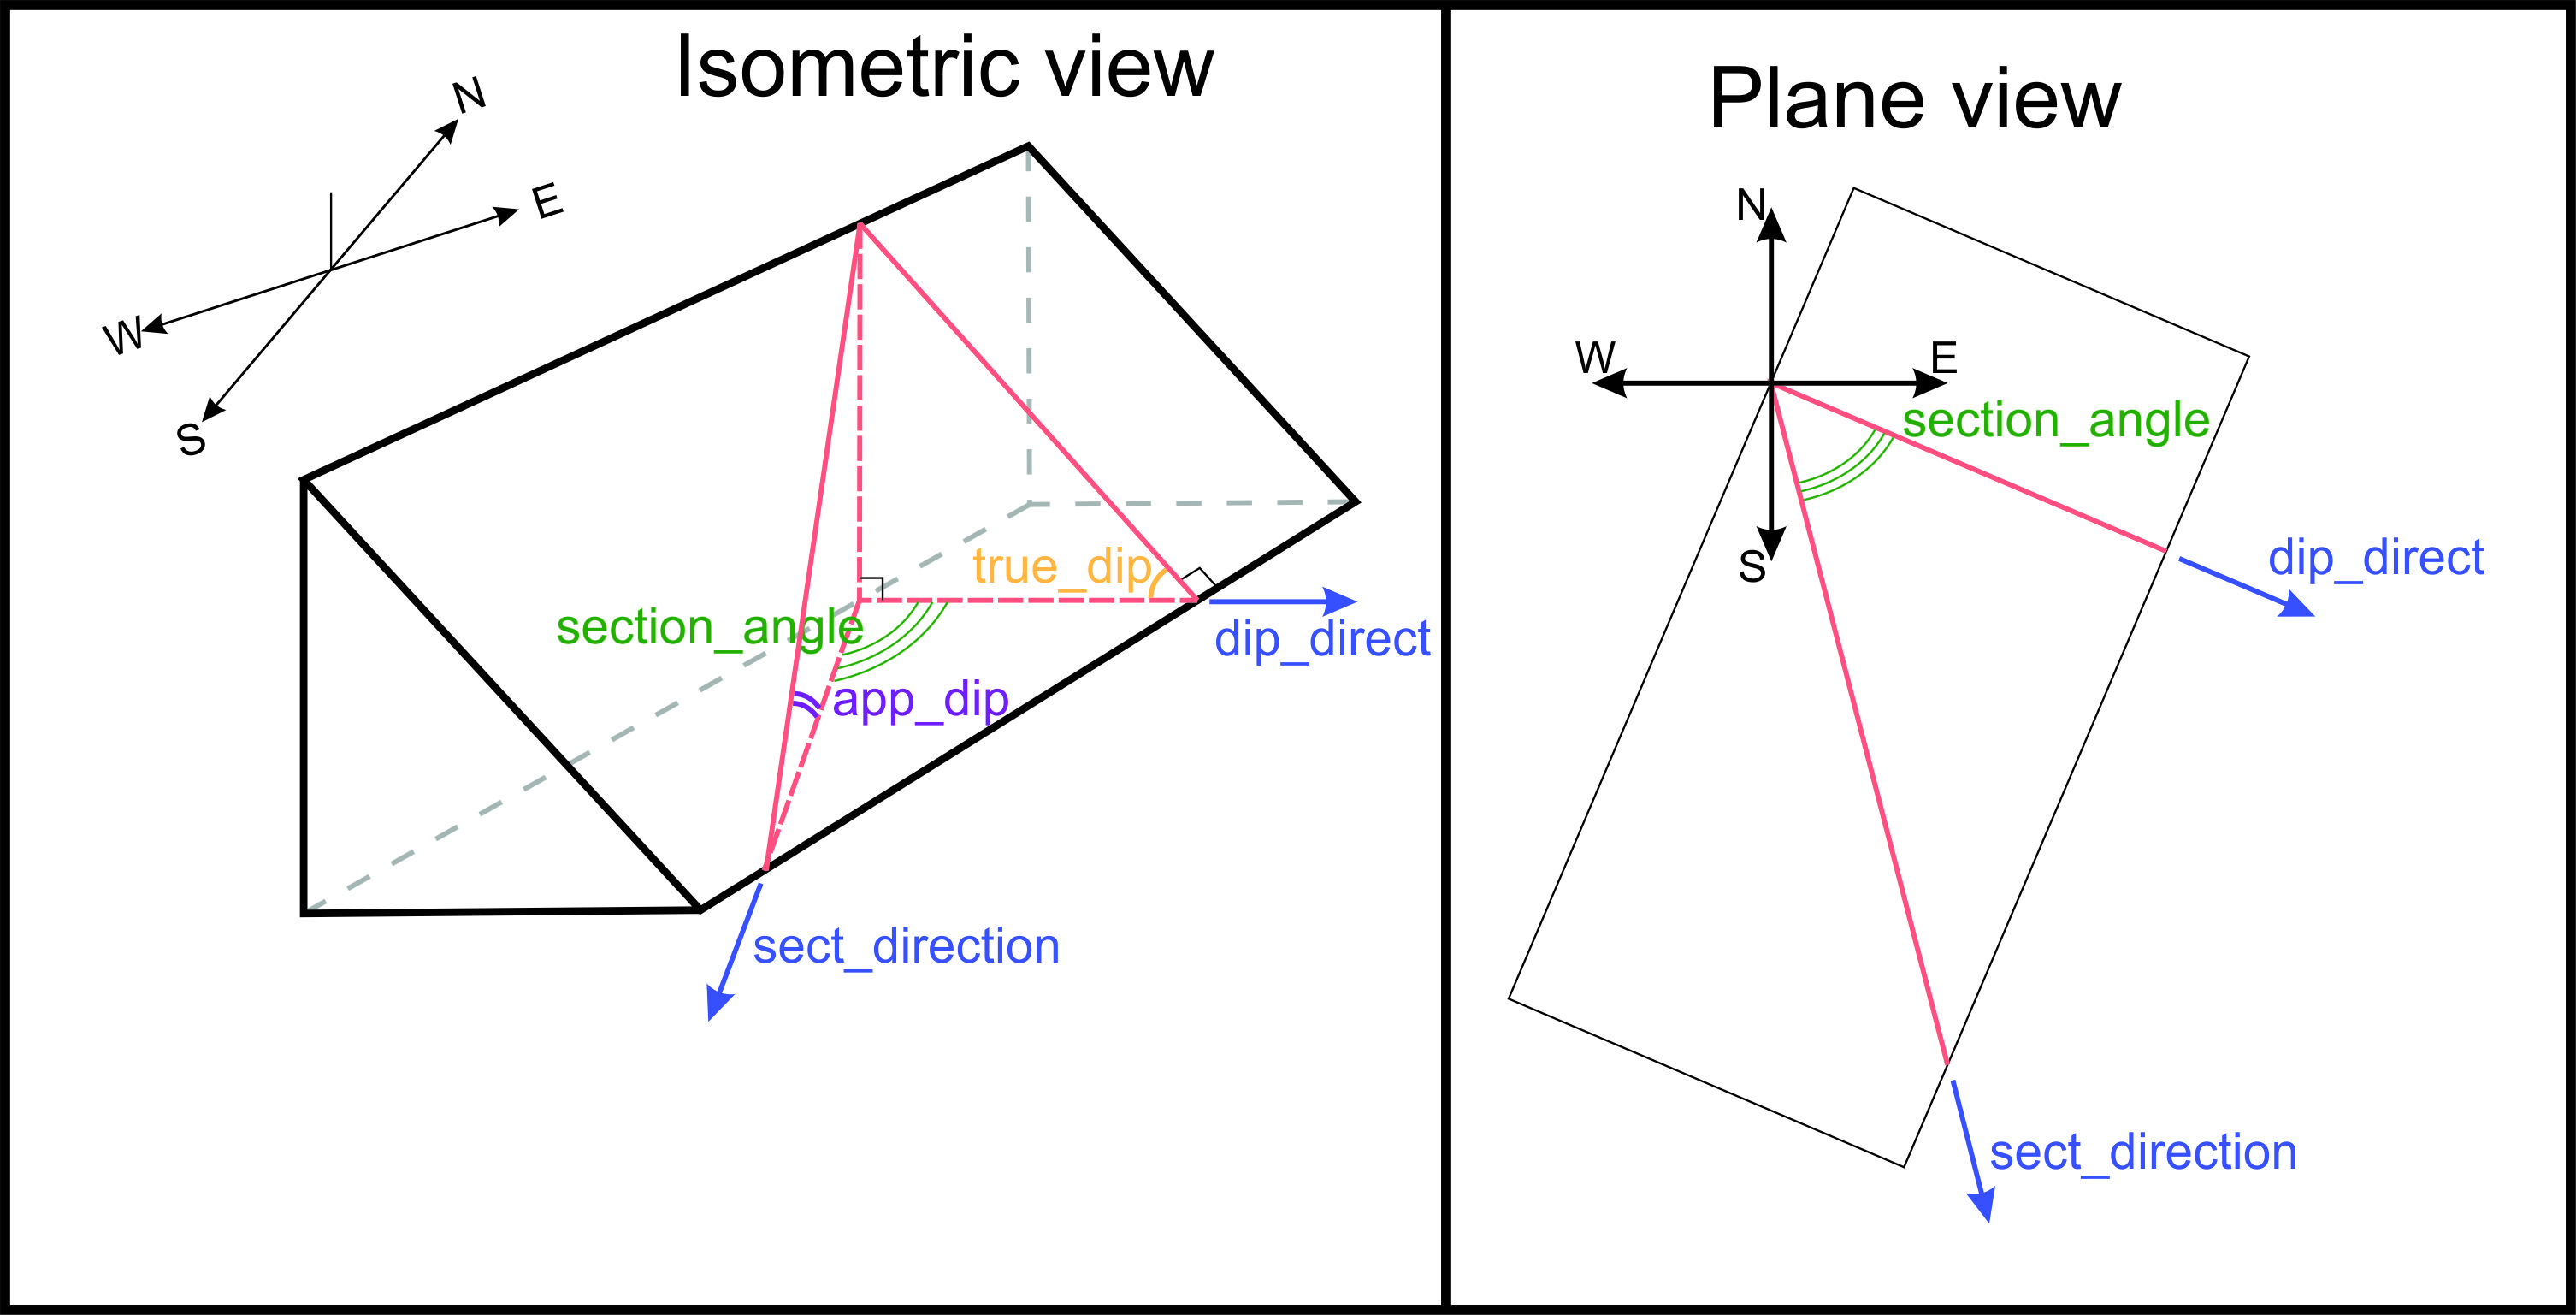

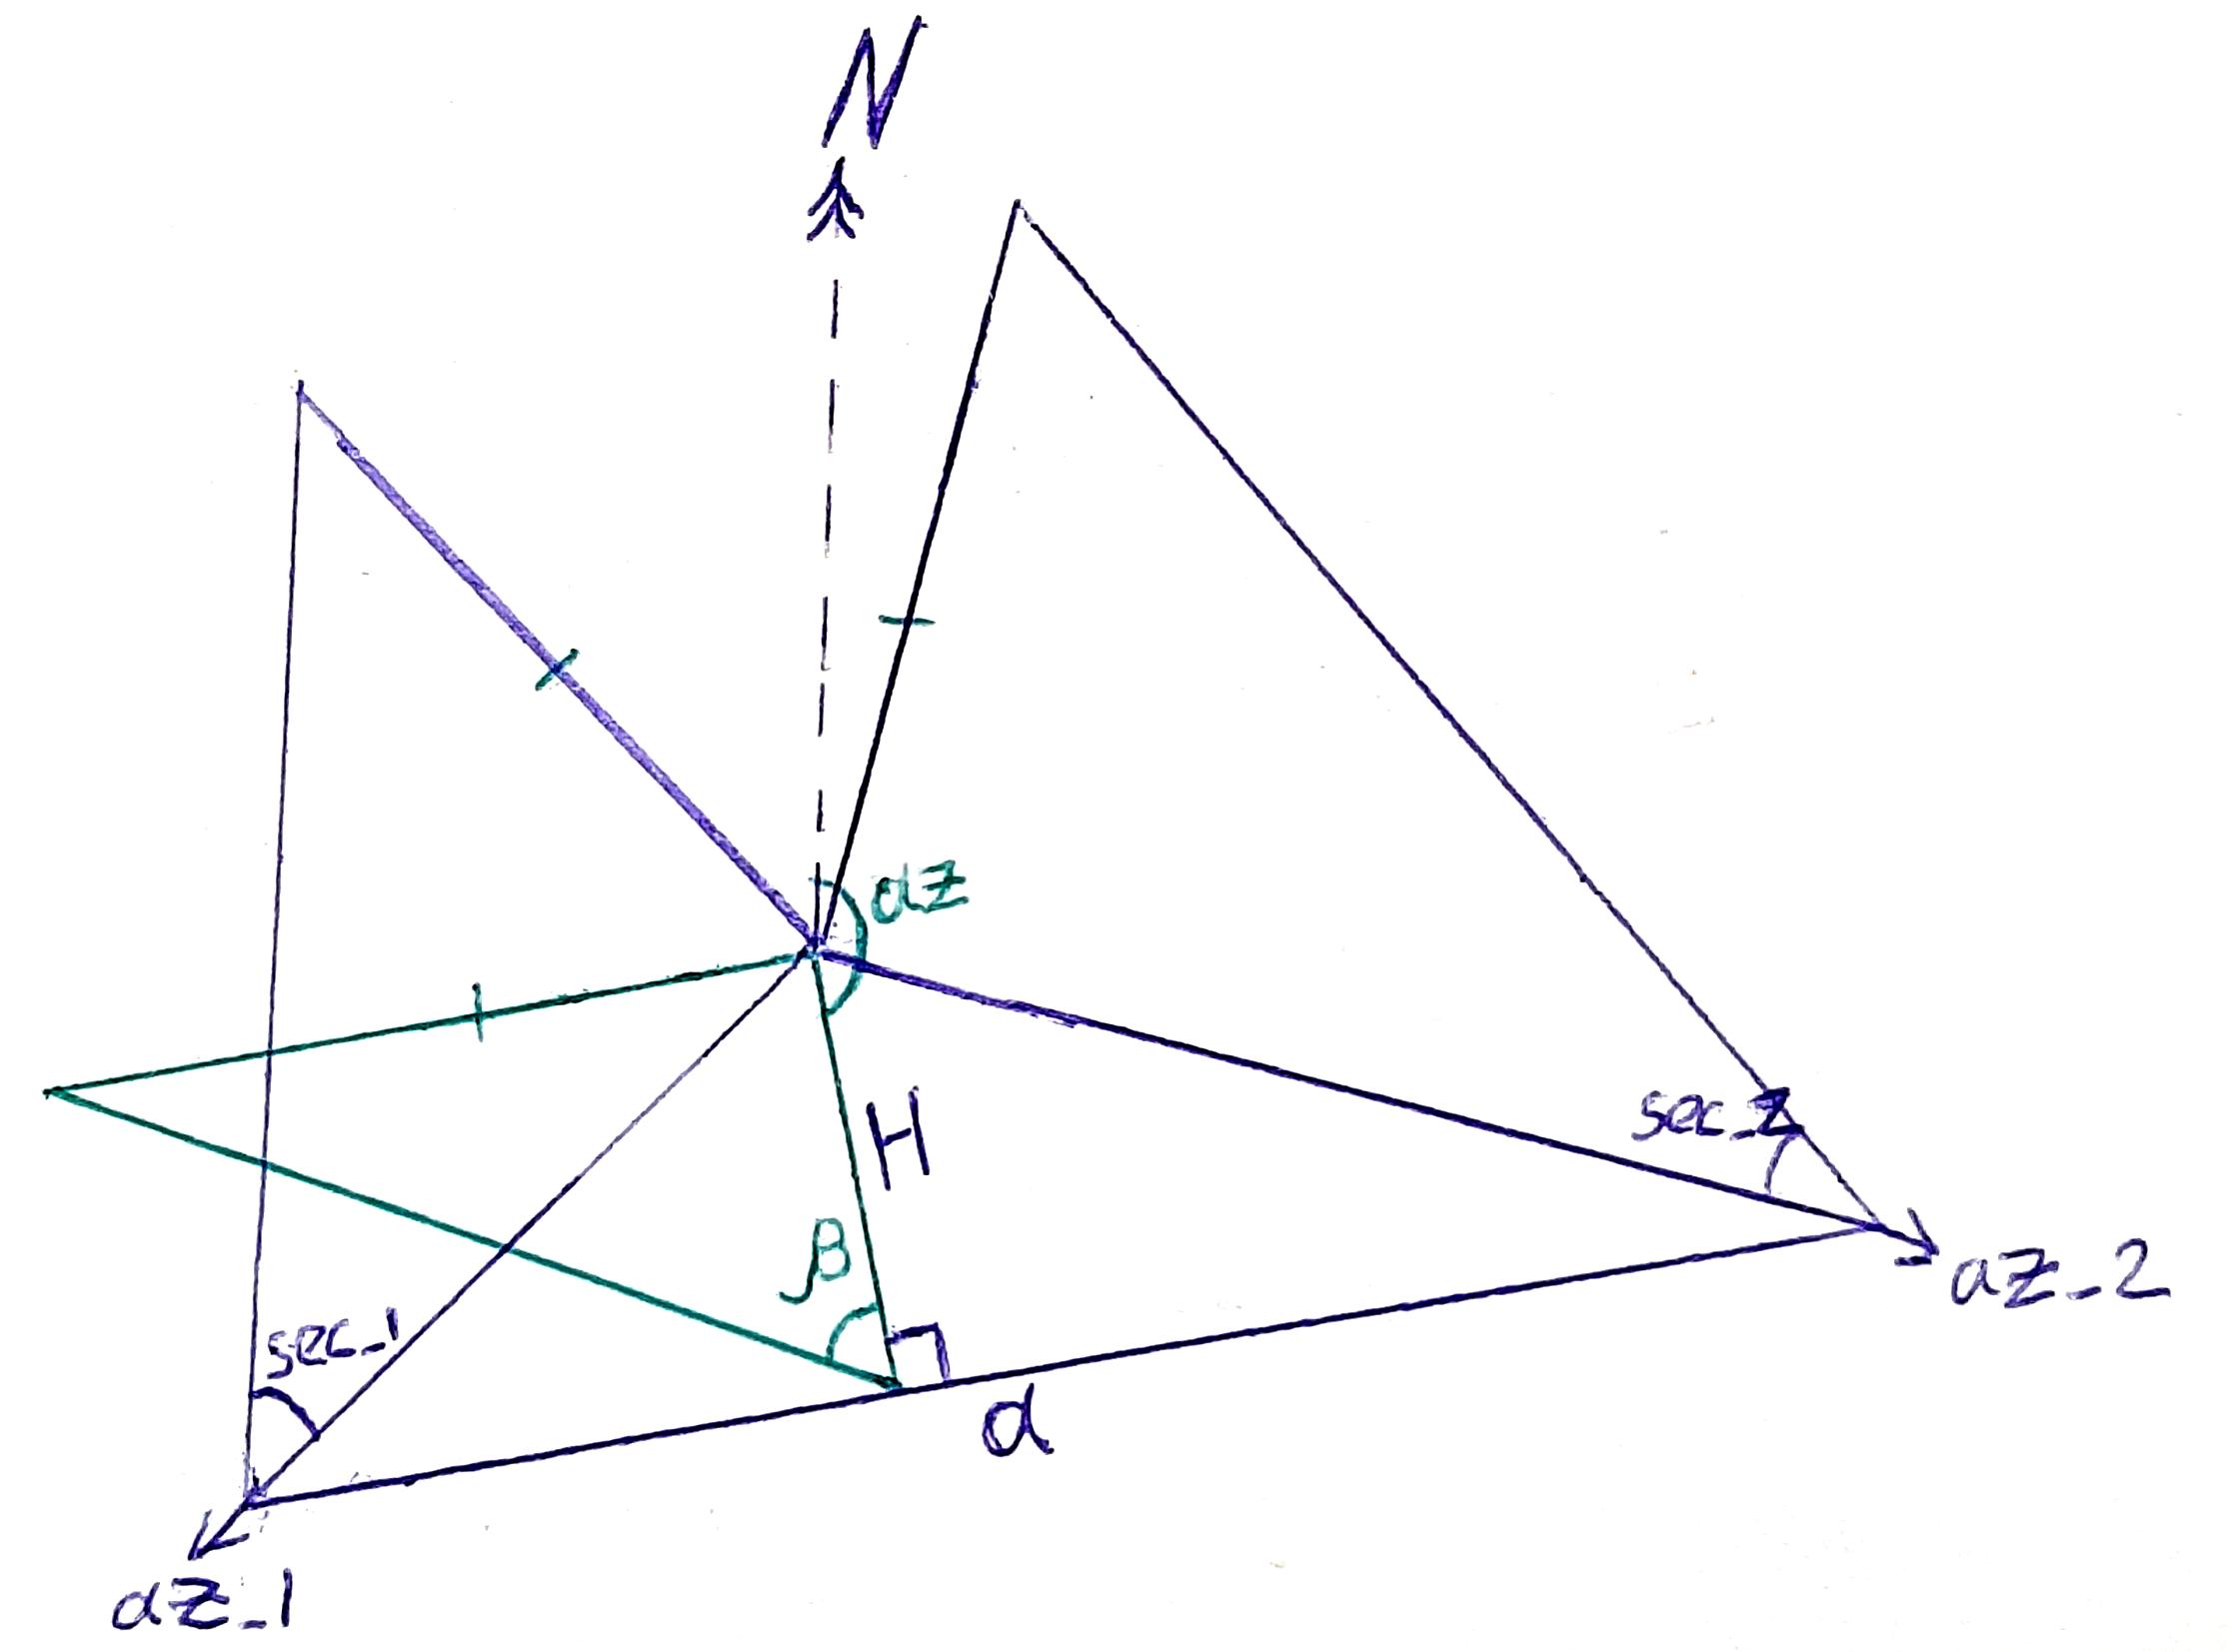

In [25]:
#Основная функция переводящая разрывы из папки с отдельными файлами разломов в базу данных вида: номер,X,Y, Угол падения, Азимут падения
def read_faults(folder_name='all_faults'):
    db=pd.DataFrame(columns=['x','y','z','name'])
    name=0
    ls=[]
    folder_name='all_faults'
    filenames=[folder_name+u'\\'+i for i in os.listdir(folder_name)]
    for filename in filenames:       #Объединение всех файлов с разломами в одну базуу данных с уникальным именем для каждого фолта
        name+=1
        new_fault=pd.read_csv(filename,sep=' ',skipinitialspace=True, usecols=[3,4,5],names=['x','y','z'])
        new_fault['name']=name
        db=db.append(new_fault)
    for fault_name in db.name.unique():
        fault=db[db.name==fault_name]
        fault=fault.drop_duplicates()
        fault.index=[i for i in range(0,len(fault))]
        x1,y1,z1=fault.loc[fault['z'].idxmax(),['x','y','z']]
        x2,y2,z2=fault.loc[fault['z'].idxmin(),['x','y','z']]
        distance=((x1-x2)**2+(y1-y2)**2)**0.5
        if distance==0 : print('fault number ',fault_name, ' is broken!')
        angle=abs(np.rad2deg(np.arctan((z2-z1)/distance)))
        azimuth=np.rad2deg(np.arctan((x1-x2)/(y1-y2)))
        if y1-y2>0: 
            azimuth=(360+azimuth)%360
        else: 
            azimuth=180+azimuth
        if azimuth>180: 
            line_az=azimuth-180
    #         angle=-angle
        else: line_az=azimuth
        ls.append([name,x1,y1,angle,line_az])
    DF=pd.DataFrame(ls, columns=['name','x','y','angle','az'])

    DF['cat_az']=pd.cut(DF['az'],18,labels=range(10,181,10))
    DF=DF[DF['angle']>25]
    return(DF)

In [ ]:
##Функция создающая модельную выборку с необходимыми параметрами.
def make_model(f_angle,f_az,s_angle=0,s_az=0,t_angle=0,t_az=0,size=1):
    f_angle=np.random.normal(f_angle,10,100)
    f_az=np.random.normal(f_az,10,100)
    if size==1:
        s_angle,s_az,t_angle,t_az=np.empty_like([]),np.empty_like([]),np.empty_like([]),np.empty_like([])
    if size>1:
        s_angle=np.random.normal(s_angle,10,100)
        s_az=np.random.normal(s_az,10,100)
        t_angle,t_az=np.empty_like([]),np.empty_like([])
    if size>2:
        t_angle=np.random.normal(t_angle,10,100)
        t_az=np.random.normal(t_az,10,100)
    angle=np.concatenate((f_angle,s_angle,t_angle))
    az=np.concatenate((f_az,s_az,t_az))
    generation=[1]*200+[2]*1
    ls=[]
    for i in range(0,181,10):
        for q in range(len(angle)):
            ls.append([abs(apparent_angle(angle[q],az[q]-i)),i,generation[q]])
    model_data=pd.DataFrame(ls,columns=['angle','az','gener'])    
    model_data['cat_az']=pd.cut(model_data['az'],18)
    model_data=model_data[model_data.angle>25]
    model_data=model_data[model_data.angle<85]
    return(model_data)

In [30]:
def print_graph(DF):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(2, rot=-.25, light=0,dark=0)
    g = sns.FacetGrid(DF[['cat_az','angle']], row='cat_az', hue='cat_az', aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "angle", clip_on=False, shade=True, alpha=0.8, lw=1.5)
    g.map(sns.kdeplot, "angle", clip_on=False, color="w", lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, color=color, fontsize=14,
                ha="left", va="center", transform=ax.transAxes)




    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=0.05)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.set(xlim=(0,90))
    g.despine(bottom=True, left=True)
    plt.show()
    plt.savefig('model_data.tif',dpi=300,cmap='gray')

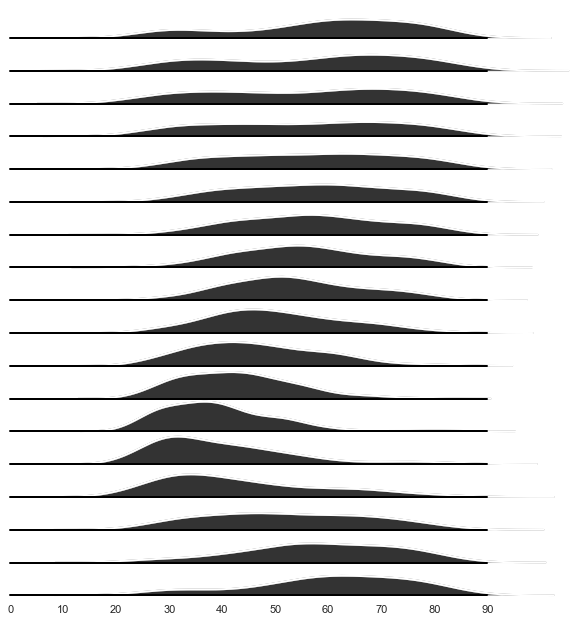

<Figure size 432x288 with 0 Axes>

In [31]:
# DF=read_faults('all_faults')              ## Чтение разломов из папки all_Faults
DF=make_model(48,80,70,220,40,0,size=2)   ## Создание модельной выборки c известными параметрами
print_graph(DF)                           ## Вывод на экран итоговой диаграммы распределения углов


In [72]:
def make_stereonet(low_angle,low_az,high_angle,high_az):
## Отрисовка стереограмки с нормалями трещин

    fig = plt.figure(figsize=(16,8))
    dips=np.concatenate((np.random.normal(low_angle,15,100),np.random.normal(high_angle,7,100)))
    strikes=np.concatenate((np.random.normal(np.rad2deg(np.deg2rad(low_az)+np.pi/2),15,100),np.random.normal(np.rad2deg(np.deg2rad(high_az)+np.pi/2),15,100)))
    # dips=np.random.normal(45,15,100)
    # strikes=np.random.normal(170,15,100)
    ax = fig.add_subplot(121, projection='stereonet')
    # ax.density_contourf(strikes, dips, measurement='poles',alpha=0.5,cmap='Greys')
    ax.grid(which='major')
    ax.pole(strikes[0:100], dips[0:100], c='k', label='Pole of the Planes',marker='+')
    ax.pole(strikes[100:], dips[100:], c='k', label='Pole of the Planes',marker='o')
    ax.legend(['АзПд 80°<45','АзПд 40° <80'],facecolor='white',fontsize=14,framealpha=1)
    plt.show()
    plt.savefig('two_systems_polar.tif',dpi=300)

In [20]:
## Чтение данных по азимутам и углам падения из Петреля и создание модельной выборки косых сечений на их основе
ls=[]
az=pd.read_csv('dip_az.csv',sep=' ',names=['name','az'])
angle=pd.read_csv('dip_angle.csv',sep=' ',names=['name','angle'])
result=pd.merge(az,angle,left_on='name',right_on='name')
for i in range(0,181,10):
    for q in range(len(result)):
        ls.append([apparent_angle(result.loc[q,'angle'],result.loc[q,'az']-i),i])
model_data=pd.DataFrame(ls,columns=['angle','az'])    
model_data['cat_az']=pd.cut(model_data['az'],18)
model_data['angle']=abs(model_data['angle'])
# model_data=model_data[model_data.angle>20]

print(model_data[::3000])

         angle   az          cat_az
0     8.950943    0   (-0.18, 10.0]
3000  7.889186  150  (140.0, 150.0]


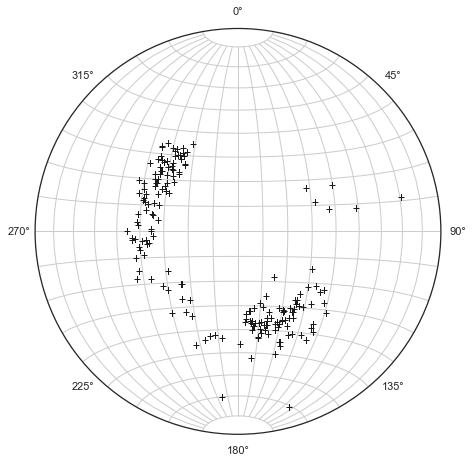

In [96]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='stereonet')
# ax.density_contourf(strikes, dips, measurement='poles',alpha=0.5,cmap='Greys')
ax.grid(which='major')
ax.pole(result['az']+90, result['angle'], c='k', label='Pole of the Planes',marker='+')
plt.savefig('Kiri.jpg',dpi=300)
